<a href="https://colab.research.google.com/github/hawkeyedatatsai/food-sales-predictions/blob/main/Heng_Tser_Tsai_Food_Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

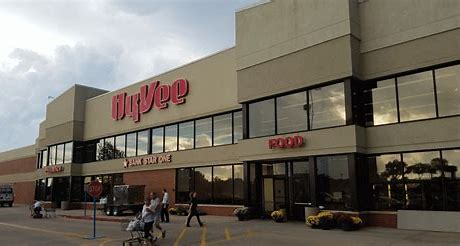

# **Food Sales Predictions**
##### Heng-Tser Tsai




---



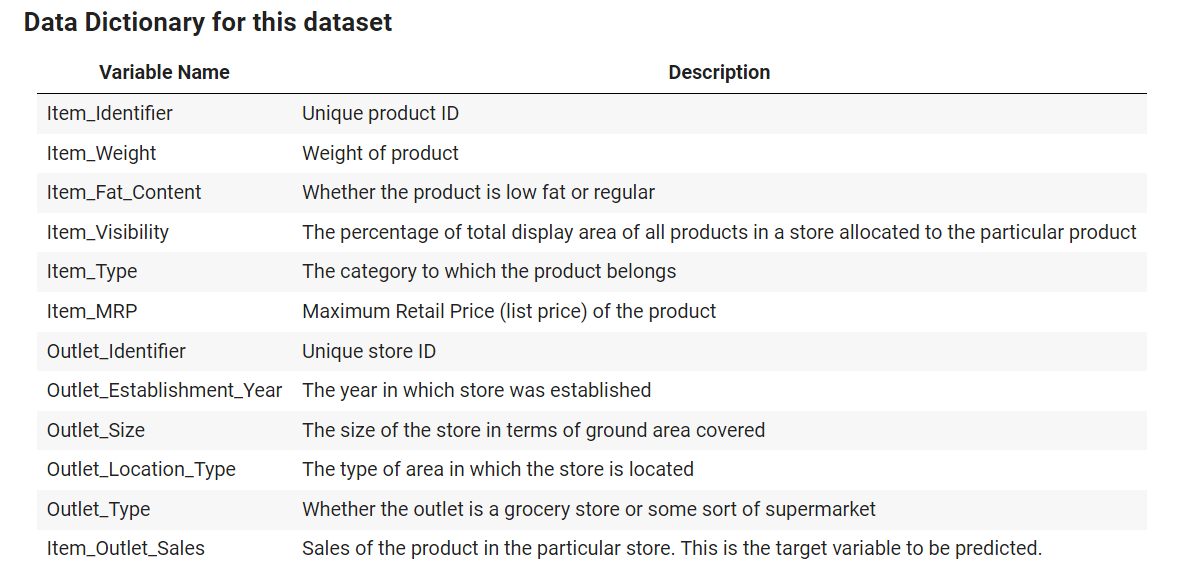

## Loading Data

**This revisited version is focusing on remaking, saving, and explaining models, data cleaning is not fully discovered.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from matplotlib.ticker import StrMethodFormatter
import joblib
filename = "sales_predictions.csv"
df = pd.read_csv(filename)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [2]:
# for evaluating a regression model using r-squared and RMSE
def evaluate_regression(model, X_train, y_train, X_test, y_test): 
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = False)
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = False)
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [3]:
#for plotting coeffs
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [4]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [5]:
## replace inconsistent categories
fat_content_map = {'LF':'Low Fat',
                   'reg':'Regular',
                   'low fat':'Low Fat'}
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(fat_content_map)
## Verify 
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Perform a train test split

In [6]:
## Define X and y
target = 'Item_Outlet_Sales'
X = df.drop(columns=target).copy()
y = df[target].copy()

## Drop unwanted/inappropriate columns 
bad_cols = ['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year']
X = X.drop(columns=bad_cols)

In [7]:
## Perform a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create a preprocessing object to prepare the dataset for Machine Learning


In [8]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, 
                                       remainder='passthrough', 
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000246864FEEC0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000246864FC820>)],
                  verbose_feature_names_out=False)

In [9]:
# transform data
#We fit the ColumnTransformer, which we called 'preprocessor' on the training data. 
#Never on testing data!

#fit on train
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# get column names
cols = preprocessor.get_feature_names_out()

#View the transformations 
X_train_df = pd.DataFrame(X_train_processed, columns=cols)
X_test_df = pd.DataFrame(X_test_processed, columns=cols)
X_test_df

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,3.310089e-01,-0.776646,-0.998816,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.179892e+00,0.100317,-1.585194,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.784469e-01,-0.482994,-1.595784,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.213344e-16,-0.415440,0.506592,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-6.426567e-01,-1.047426,0.886725,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,1.113736e+00,-1.134688,0.473646,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2127,-6.426567e-01,-1.291052,0.018124,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2128,-1.139570e+00,1.218324,1.093980,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2129,-1.497727e+00,-0.778096,-0.366800,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
y_test.head()

7503    1743.0644
2957     356.8688
7031     377.5086
1084    5778.4782
856     2356.9320
Name: Item_Outlet_Sales, dtype: float64

# Modeling 1: Linear Regression



## Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.

In [11]:
# apply linear regression and display coefficients using a pre-defined function
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)

LinearRegression()

In [12]:
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1140.32
Test Data:	R^2= 0.57	RMSE= 1094.76


## Extract and visualize the coefficients that your model determined.


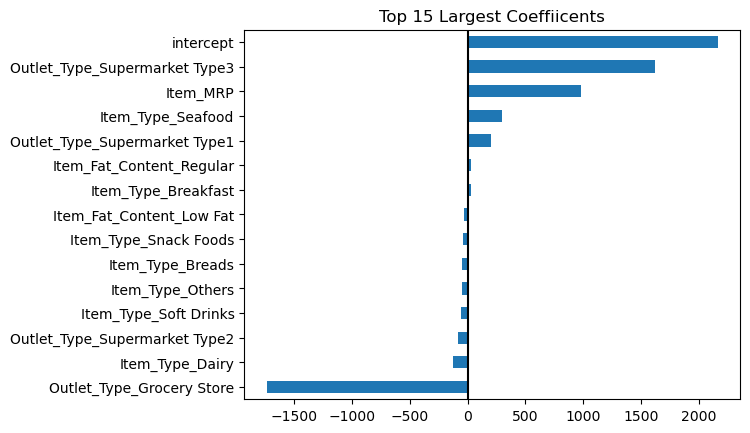

In [13]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_

## rank the coeffs and select the top_n
top_n = 15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()

## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');
plt.savefig('lin-reg.png')

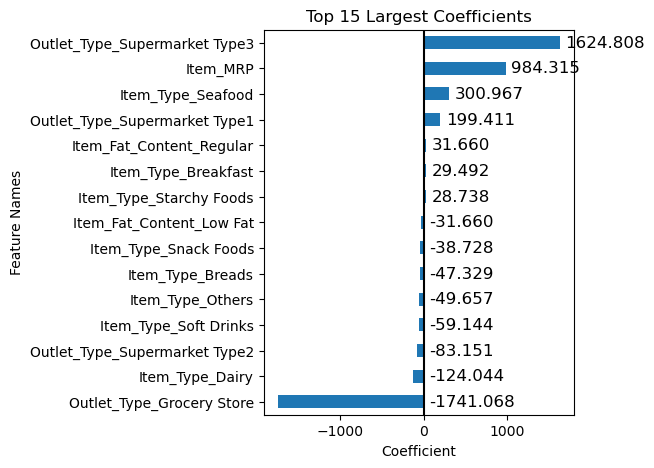

In [14]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

## Top 3 most important features

- Outlet_Type_Supermarket Type3: 
Being in the Type 3 Supermarket group increases the item outlet sales by 1624.808.

- ITEM MRP:
Being in the ITEM MRP group increases the item outlet sales by 984.315

- ITEM TYPE Seafood:
Being in the ITEM TYPE SEAFOOD increases the item outlet sales by 300.967. Seafood are usually more expensive since it is harder to raise and get.

# Modeling 2: Decision Tree Regression

## Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.

In [15]:
dec_tree= DecisionTreeRegressor()
dec_tree.fit(X_train_df,y_train)

DecisionTreeRegressor()

In [16]:
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.11	RMSE= 1568.41


## Extract and visualize the coefficients that your model determined.


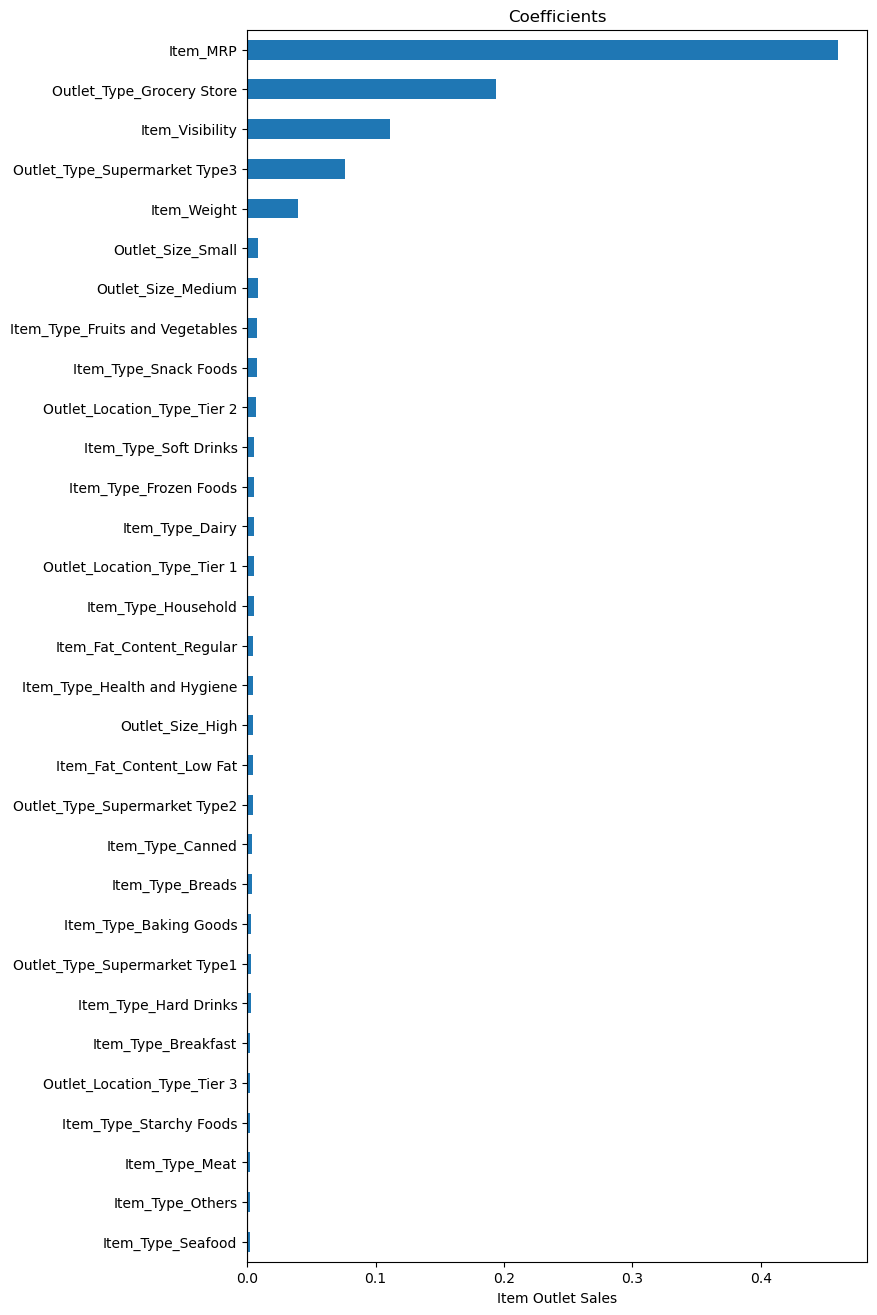

In [17]:
coeffs = pd.Series(dec_tree.feature_importances_, index=feature_names,
                        name='Feature Importances')
## Plot everything but outlet identifier
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Coefficients");
plt.savefig('dec-tree.png')

## Top 5 most important features

- Outlet_Type_Grocery Store

- ITEM MRP

- ITEM Visibility

- Outlet_Type_Supermarket Type3

- ITEM Weight

# Modeling 3: Tuned Decision Tree Regression

Model 2 is overfitting on train data and R2 is only .10 on test data. so it is not explaining too much, decide to tune it and see it the results are the same.

In [18]:
# What was the depth of our default tree?
dec_tree.get_depth()

42

In [19]:
#try loop through 2 and 42 and see which depth would give the best score
depths= list(range(2, 42))
scores = pd.DataFrame(index=depths, columns=["Test Score","Train Score"])

for depth in depths:
  dec_tree=DecisionTreeRegressor(max_depth=depth, random_state=42)
  dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
  dec_tree_pipe.fit(X_train, y_train)
  train_score=dec_tree_pipe.score(X_train, y_train)
  test_score=dec_tree_pipe.score(X_test, y_test)
  scores.loc[depth, "Train Score"] = train_score
  scores.loc[depth, "Test Score"] = test_score

,Test Score,Train Score
5,0.59471,0.60394
4,0.584005,0.582625
6,0.582408,0.615072
7,0.578864,0.626453
8,0.566687,0.642724


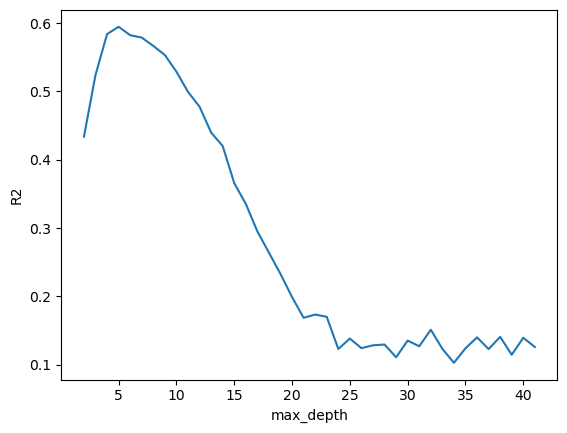

In [20]:
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

#sort to see which max_depth gives best score
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

## Extract and visualize the coefficients that your model determined.


In [21]:
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_df,y_train)
evaluate_regression(dec_tree_5, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.60	RMSE= 1082.65
Test Data:	R^2= 0.59	RMSE= 1057.44


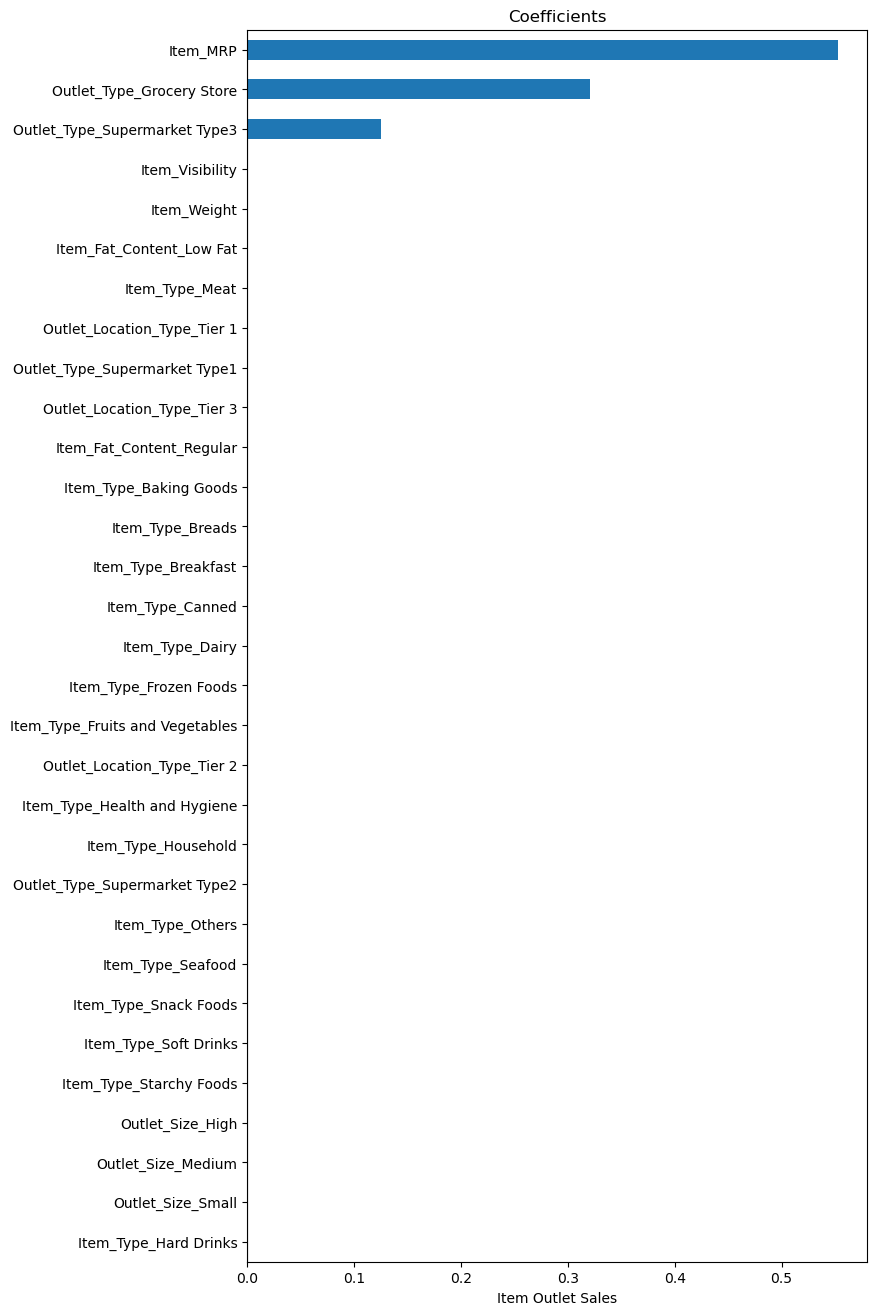

In [22]:
coeffs = pd.Series(dec_tree_5.feature_importances_, index=feature_names,
                        name='Feature Importances')
## Plot everything but outlet identifier
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Coefficients");
plt.savefig('tuned_dec-tree.png')

## Top 3 most important features

- ITEM MRP

- Outlet_Type_Grocery Store

- Outlet_Type_Supermarket Type3

# Serialize the Best Models with Joblib

In [23]:
export = {'preprocessor': preprocessor,
          'X_train':X_train_df,
          'y_train': y_train,
          'X_test':X_test_df,
          'y_test': y_test,
          'DecisionTreeRegressor': dec_tree_5 }
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']